# PACE Rapid Response Workflow

This Jupyter notebook serves as the first of hopefully many examples to rapidly access, download, review, and develop science data products is support of the NASA PACE Mission. In this notebook we investigate the impacts of Hurricane Erin that formed in mid-August of 2025. In particular we attempt to analyze different ecologically relevant biogeochemical parameters before and after the extreme strom off the southeastern shore of the United States.

Graham Trolley & Matthew Kehrli

NASA Ocean Ecology Laboratory

September 2025

### Case Study Information

Hurricane Erin, look at chl-a before and after hurricane off FL coast
- Hurricanes tend to increase productivity
Timeline (using worldview): 
- Hurricane off florida/gulf stream PACE imagery on AUG 20
- Aug 21, hurricane passed and clear imagery
- Aug 18/19 hurricane not there yet

*post Aug 21, there is a PACE safehold so no data. But, the imagery from Aug21 immediately post hurricane is enough for this example script


### Basic Steps
- Use worldview to identify an event and region of interest to examine (basic before/after)
- define lat lon bounds, and time range for pre- and post-event averages
- earthdata search using parameters. Open the first one by itself to establish gridding params
- use dask to open all the pre-event granules
- use dask to open all the post-event granules
- make some initial analysis plots
- return pre and post dataframes to user, to allow them to make more custom plots

### Imports

In [1]:
import cartopy.crs as ccrs
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.colors import LogNorm
import cmocean
from dask.distributed import Client
from matplotlib.patches import Rectangle

### User Defined Functions

In [2]:
# Define Functions
def grid_match(path, dst_crs, dst_shape, dst_transform):
    """Reproject a Level-2 granule to match a Level-3M-ish granule."""
    dt = xr.open_datatree(path)
    da = dt["geophysical_data"]["chlor_a"]
    da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
    da = da.rio.set_crs("epsg:4326")
    da = da.rio.reproject(
        dst_crs,
        shape=dst_shape,
        transform=dst_transform,
        src_geoloc_array=(
            dt["navigation_data"]["longitude"],
            dt["navigation_data"]["latitude"],
        ),
    )
    da = da.rename({"x":"longitude", "y":"latitude"})
    return da

def time_from_attr(ds):
    """Set the start time attribute as a dataset variable.
 
    Parameters
    ----------
    ds
        a dataset corresponding to a Level-2 granule
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["time"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("time")
    return ds

### Event Timeline and Geographic Information

In [3]:
# User definitions:

pre_tspan = ("2025-08-18", "2025-08-20")
post_tspan = ("2025-08-21", "2025-08-22")

min_lon = -82
min_lat = 27.8
max_lon = -70
max_lat = 32.1

suite_name="PACE_OCI_L2_BGC_NRT" # oci suite name
var_name = "chlor_a"

in_the_cloud = False # set to true if running in cloud, false if running locally. For speed, granules will be downloaded to a local_data directory when set to false

##
bbox = (min_lon, min_lat, max_lon, max_lat)

In [4]:
'''One large cell to load in all relevant pre-event and post-event granules
Steps:
- Earth access search to make lists of pre and post event files
- Open first entry of list manually, manipulate to L3M-like format and store relevant grid configuration info
- Using dask, open pre and post event granules, recast to L3M-like mapped format, trim to spatial extent, combine 2 datasets
- Make some default plots to visualize Pre and Post event data
'''

pre_results = earthaccess.search_data(
    short_name=suite_name,
    temporal=pre_tspan,
    bounding_box=bbox,
)
print(" Number of pre-event granules: "+str(len(pre_results)))

post_results = earthaccess.search_data(
    short_name=suite_name,
    temporal=post_tspan,
    bounding_box=bbox,
)
print(" Number of post-event granules: "+str(len(post_results)))


# in running this script in the cloud, earthaccess.open is fast, but when running locally it takes a long time, and locally downloading the data is faster.
# so, get the data with different approaches, depening on whether you are in the cloud or not, defined above
if in_the_cloud == True:
    pre_paths = earthaccess.open(pre_results, local_path="data")
    post_paths = earthaccess.open(post_results, local_path="data")
else:
    pre_paths = earthaccess.download(pre_results, local_path="local_data/")
    post_paths = earthaccess.download(post_results, local_path="local_data/")
    print('Files Downloaded')

# Part 1: load first file in pre_paths, manipulate to L3M-like, store geo info

datatree = xr.open_datatree(pre_paths[0])
dataset = xr.merge(datatree.to_dict().values())
dataset = dataset.set_coords(("longitude", "latitude"))

var_data = dataset[var_name]# use code from dask_gridding notebook to transform L2 granule to L3M-like grid
var_data = var_data.rio.set_spatial_dims("pixels_per_line", "number_of_lines")
var_data = var_data.rio.write_crs("epsg:4326")
var_L3M = var_data.rio.reproject(
    dst_crs="epsg:4326",
    src_geoloc_array=(
        var_data.coords["longitude"],
        var_data.coords["latitude"],
    ),
)
var_L3M = var_L3M.rename({"x":"longitude", "y":"latitude"})

var_L3M_aoi = var_L3M.sel({"longitude": slice(bbox[0], bbox[2]),"latitude": slice(bbox[3], bbox[1])})

crs = var_L3M_aoi.rio.crs# set mapping parameters from newly transformed file, to use when opening the rest with dask
shape = var_L3M_aoi.rio.shape
transform = var_L3M_aoi.rio.transform()

# part 2: using dask, open all the data in pre_paths and post_paths
# 2a load pre event files
client = Client()
pre_futures = client.map(grid_match,pre_paths,dst_crs=crs,dst_shape=shape,dst_transform=transform)
kwargs = {"combine": "nested", "concat_dim": "time"}
pre_attrs = xr.open_mfdataset(pre_paths, preprocess=time_from_attr, **kwargs)
pre_data = xr.combine_nested(client.gather(pre_futures), concat_dim="time")# open  all pre files. they are stored in same xarray dataset at different "time" coordinates 
pre_data["time"] = pre_attrs["time"]
#client.close()
print('loaded pre event files')

# 2b post event files
client = Client()
post_futures = client.map(grid_match,post_paths,dst_crs=crs,dst_shape=shape,dst_transform=transform)
kwargs = {"combine": "nested", "concat_dim": "time"}
post_attrs = xr.open_mfdataset(post_paths, preprocess=time_from_attr, **kwargs)
post_data = xr.combine_nested(client.gather(post_futures), concat_dim="time")# open all post files. they are stored in same xarray dataset at different "time" coordinates 
post_data["time"] = post_attrs["time"]
client.close()
print('loaded post event files')

 Number of pre-event granules: 5
 Number of post-event granules: 2


QUEUEING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/5 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

Files Downloaded


C:\Users\gtrolley\AppData\Local\Temp\ipykernel_24184\4126672406.py:36: FutureWarning: In a future version, xarray will not decode the variable 'day' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  datatree = xr.open_datatree(pre_paths[0])
C:\Users\gtrolley\AppData\Local\Temp\ipykernel_24184\4126672406.py:36: FutureWarning: In a future version, xarray will not decode the variable 'msec' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is 

loaded pre event files


c:\Users\gtrolley\AppData\Local\miniforge3\envs\prr\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60955 instead
  warnings.warn(


loaded post event files


2025-09-03 02:30:07,753 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 7 memory: 145 MB fds: 194>>
Traceback (most recent call last):
  File "/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/tornado/ioloop.py", line 945, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mkehrli/miniforge3/envs/hackweek/lib/python3.12/site-packages/psutil/__init__.py", line 2148, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory
2025-09-03 04:15:49,763 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 7 memory: 157 MB fds: 196>>
Tr

Text(0.5, 1.0, 'post_hurricane 8/21')

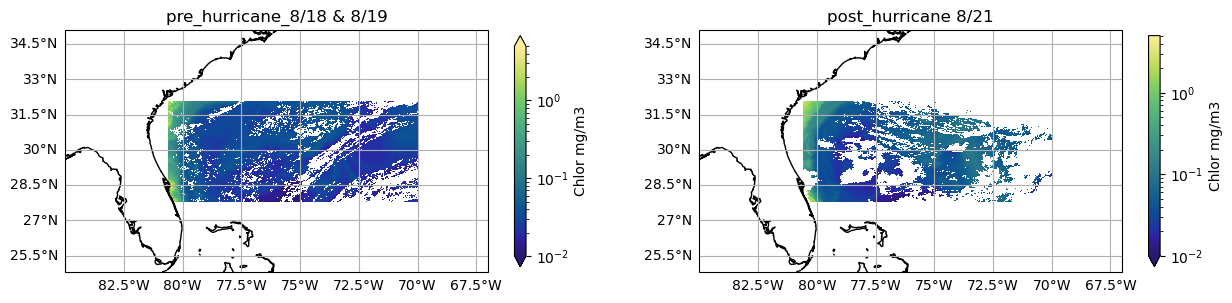

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = pre_data.mean("time").plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[0], robust=True)
ax[0].set_xlim(bbox[0]-3,bbox[2]+3,)
ax[0].set_ylim(bbox[1]-3,bbox[3]+3)
ax[0].coastlines()
ax[0].set_title('pre_hurricane_8/18 & 8/19')


ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_data.mean("time").plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[1], robust=True)
ax[1].set_xlim(bbox[0]-3,bbox[2]+3,)
ax[1].set_ylim(bbox[1]-3,bbox[3]+3)
ax[1].coastlines()
ax[1].set_title('post_hurricane 8/21')


Text(0.5, 1.0, 'post_hurricane higher chla')

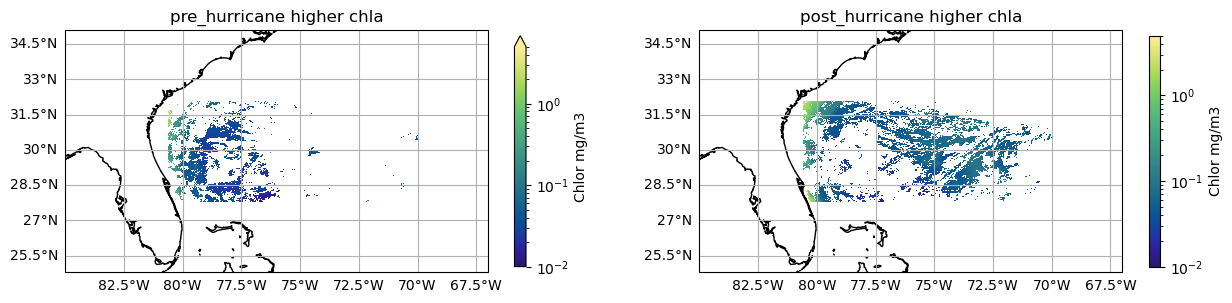

In [6]:
# compare the pre and post event data. first, mask both to only pixels where data is available before and after the hurricane
# then, mask each where it's values are greater or less than

pre_mean = pre_data.mean("time")
post_mean = post_data.mean("time")

post_mean['longitude'] = post_mean['longitude'].round(5)# round lat/lon to 5 decimals, was having issues with floats at large # of decimals not being exactly the same
post_mean['latitude'] = post_mean['latitude'].round(5)
pre_mean['longitude'] = pre_mean['longitude'].round(5)
pre_mean['latitude'] = pre_mean['latitude'].round(5)

# Create a mask where both datasets have valid values
mask = ~np.isnan(post_mean) & ~np.isnan(pre_mean)

# Apply mask to both datasets
post_mean_mask = post_mean.where(mask)
pre_mean_mask = pre_mean.where(mask)

# new mask to show where post > pre and vice versa
mask2 = post_mean<pre_mean
mask3 = post_mean>pre_mean

# Apply mask to both datasets
pre_mean_mask = pre_mean_mask.where(mask2)# locations where chla is higher pre hurricane
post_mean_mask = post_mean_mask.where(mask3)# locations where chla is higher post hurricane


fig, ax = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax[0].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = pre_mean_mask.plot(x="longitude", y="latitude" , cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[0], robust=True)
ax[0].set_xlim(bbox[0]-3,bbox[2]+3,)
ax[0].set_ylim(bbox[1]-3,bbox[3]+3)
ax[0].coastlines()
ax[0].set_title('pre_hurricane higher chla')

ax[1].gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = post_mean_mask.plot(x="longitude", y="latitude", cbar_kwargs={'label': 'Chlor mg/m3', 'shrink':0.5}, cmap=cmocean.cm.haline,norm=LogNorm(vmin=.01, vmax=5),  ax=ax[1], robust=True)
ax[1].set_xlim(bbox[0]-3,bbox[2]+3,)
ax[1].set_ylim(bbox[1]-3,bbox[3]+3)
ax[1].coastlines()
ax[1].set_title('post_hurricane higher chla')
